# Práctica Final
## Estudio de las fluctuaciones de la bolsa debido a la influencia en redes sociales de personajes públicos

### Importación de librerías

In [1]:
import numpy as np
import pandas as pd
import random
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from textblob import TextBlob
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression

sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)

### Funciones

Sentimiento para una palabra (Análisis de polaridad)

Para realizar el análisis de sentimiento de un tweet de Donald Trump, se hace uso de la librería TextBlob. Esta librería tiene como herramienta para este análisis una función llamada sentiment.polarity.


Sentiment funciona de tal manera que analiza la frase, y les asigna un valor en función del tipo de palabra que sea. En primer lugar busca sustantivos, de esa manera se puede saber cuántos objetos de interés hay en la frase. Posteriormente, analiza cada uno de los sustantivos y en función de el o los posibles significados de esa palabra, tienen asociados los siguientes valores:

- Polaridad, que mide lo negativa o positiva que es este significado (entre -1 y 1).
- Subjetividad, que intenta cuantificar lo objetivo vs lo subjetivo (entre 0 y 1).
- Intensidad, que mide el énfasis que da la palabra a la propia frase (con valores entre 0,2 y 2).

Finalmente, la función analiza el resto de las palabras de la frase y realiza un producto final de los valores por separado, y obteniendo así el valor de la polaridad, subjetividad e intensidad de una frase entera. Para realizar un estudio más eficiente, la propia función normaliza las palabras que tengan una forma más simple (por ejemplo, “running” y “ran” tienen el mismo significado que “run”).

Para la asignación de los valores se utiliza una estructura xml que asocia una serie de valores a cada palabra.

In [2]:
def word_sentiments(word, tweet_df):
    tweet_batch = tweet_df.loc[tweet_df.loc[:, 'text'].str.contains(fr'\b{word}')].copy()
    
    sentiments = []
    for tweet in tweet_batch['text']:
        sentiments.append(TextBlob(tweet).sentiment.polarity)
    
    tweet_batch['sentiment'] = sentiments
    
    return tweet_batch

Sentimiento para las compañias

In [3]:
def get_companies_transactions(companies, tweets_df, stocks_df, window, view_data=False):
    
    polarities, differences, related_company = [] , [], []
    for company in companies:
        
        tweets = word_sentiments(company, tweets_df)
        company_stocks = stocks_df.loc[stocks_df.loc[:,"name"].str.contains(fr'\b{company.upper()}')].copy()
        
        for _, tweet in tweets.iterrows():
            
            open_ = company_stocks.loc[company_stocks["date"]==tweet.created_at.date(), "open"]
            
            if len(open_) == 0:
                for _, row in company_stocks.iterrows():
                    if row.date.date() > tweet.created_at.date():
                        open_ = company_stocks.loc[company_stocks['date'] == row.date, 'open']
                        break
                        
            close_ = company_stocks.loc[open_.index + window,"close"]
            dif_ = (close_.values - open_.values)/open_.values*100
            
            polarities.append(tweet.sentiment)
            differences.append(dif_)
            related_company.append(company)
    
    if view_data:
        plot_stats(polarities, differences)
    
    return polarities, differences, related_company        
    

Cálculo de regresiones

In [4]:
def get_regression(polarities, differences, horizon):
    print(f'{horizon+1} día(s) de bolsa contabilizado(s)')
    
    pol = np.asarray(polarities)
    diff = np.asarray(differences)
    diff = diff.reshape(-1)
    
    coe_pearson = stats.pearsonr(pol, diff)
    print('Hemos obtenido un r = {}' .format(coe_pearson[0]))
    
    X_pred = np.empty(shape=[10,])
    for i in range(0,10):
        a = random.uniform(-1, 1)
        X_pred[i] = a

    X_pred = X_pred.reshape(-1 , 1)

    pol = pol.reshape(-1,1)
    diff = diff.reshape(-1,1)
    
    regr = LinearRegression()

    regr.fit(pol, diff)

    predicts = regr.predict(X_pred)
    print('Coeficiente de la regresión: \n', regr.coef_)
    print('Mean Square Error de la regresión: \n', metrics.mean_squared_error(pol, diff))
    plot_stats(pol, diff, reg_info=[X_pred, predicts])

Analisis completo

In [5]:
def full_analysis(companies, tweets, stocks, windows):
    
    for window in range(windows):
        polarities, differences, _ = get_companies_transactions(companies, tweets, stocks, window)
        get_regression(polarities, differences, window)

Visualización

In [6]:
def plot_stats(polarities, differences, reg_info=None):
    
    plt.xlim((-1, 1))
    plt.ylim((-5, 5))
    
    plt.xlabel('Tweet polarity')
    plt.ylabel('Stock trend')
    plt.title('Trump tweets vs stocks')
    
    plt.scatter(polarities, differences, c=differences, cmap='RdYlGn')
    if reg_info is not None:
        X_pred, predicts = reg_info
        plt.scatter(X_pred, predicts,  color='b', label='predicted')
        plt.plot(X_pred, predicts, linewidth=1, linestyle='dashed', label='regression line')
        plt.legend()
    
    plt.grid(True)
    plt.show()

### Preprocesamiento

#### Carga de los tweets

In [7]:
tweets = pd.read_csv('trump_tweets.csv')

##### Object column to datetime

Convertimos la columna created at a datetime para poder realizar operaciones con ellas más adelante

In [8]:
tweets.loc[:,'created_at'] = pd.to_datetime(tweets.loc[:,'created_at'])

Filtramos las fechas fuera de scope. Esto se hace porque el dataset de la bolsa del que disponíamos solo tiene datos hasta el 24 de agosto de 2018. También acotamos las fechas desde que Donald Trump es presidente.

In [9]:
tweets = tweets.loc[tweets['created_at'] >= datetime.strptime('2017-01-20', "%Y-%m-%d").date()]
tweets = tweets.loc[tweets['created_at'] <= datetime.strptime('2018-08-24', "%Y-%m-%d").date()]

##### To lowercase

Para facilitarnos la búsqueda de palabras claves entre los tweets de nuestro presidente americano favorito lo pasamos todo a minúsculas

In [10]:
tweets['text'] = tweets['text'].str.lower() 

#### Bolsa

Para el dataset de la bolsa hemos empleado el siguiente: https://www.kaggle.com/ehallmar/daily-historical-stock-prices-1970-2018
Contiene datos diarios para empresas de los índices bursátiles NYSE y NASDAQ. Los datos que contiene un registro del dataset son precio de apertura, de cierre, máximo, mínimo y el volumen de transacciones para una empresa y para un día en concreto.

In [11]:
bolsa = pd.read_csv('bolsa.csv', index_col=0)
bolsa = bolsa.reset_index(drop=True)

##### Value at open vs value at close

Calculamos la diferencia porcentual que se ha producido en un día.

In [12]:
bolsa['difference'] = (bolsa['close'] - bolsa['open'])/(bolsa['open']) * 100

##### Column stating if the values went down 

Marcamos si los valores subieron o bajaron ese día.

In [13]:
bolsa['goes_down'] = bolsa['difference'] < 0

##### To datetime

Pasamos la columna de fechas a tipo fecha

In [14]:
bolsa.loc[:,'date'] = pd.to_datetime(bolsa.loc[:,'date'])

#### Tickers

Cargamos el otro csv que contiene los identificadores de las empresas con sus nombres oficiales y sus siglas de la bolsa.


In [15]:
tickers = pd.read_csv('historical_stocks.csv')

##### Bolsa w/ extended info

Aquí añadimos a cada registro de la bolsa la información asociada a la empresa juntándolo por ticker name

In [16]:
bolsa_ext = pd.merge(bolsa, tickers, on=['ticker'])

##### Tweets por cada empresa

Para empezar comenzamos buscando que empresas habían sido las más atacadas por Donald Trump durante su legislatura.
En vez de buscar en los tweets de forma ciega, comenzamos encontrando aquellos en los que había alguna mención a dicha empresa, para analizar la polaridad que tenía tal tweet. Algunas de las fuentes en las que nos basamos fueron:

- https://money.cnn.com/2018/04/04/news/companies/trump-companies-attacks/index.html

In [17]:
empresas = ['amazon', 'facebook', 'general motors', 'toyota', 'alphabet', 'ibm', 'apple', 'microsoft', 'netflix', 'american airlines', 'amd', 'ebay', 'tesla', 'alibaba']

A continuación, hicimos un estudio de las veces que el señor Donaldo había mencionado directamente a las empresas en sus tweets.

In [18]:
tweet_count = []
tweet_collection = []
for empresa in empresas:
    batch = word_sentiments(empresa, tweets)
    tweet_count.append(len(batch))
    tweet_collection.append(batch)

zipped = list(zip(empresas, tweet_count))

for pair in zipped:
    print(pair)

('amazon', 21)
('facebook', 8)
('general motors', 1)
('toyota', 3)
('alphabet', 0)
('ibm', 0)
('apple', 4)
('microsoft', 0)
('netflix', 0)
('american airlines', 1)
('amd', 0)
('ebay', 0)
('tesla', 0)
('alibaba', 0)


Como se puede ver, algunas de las empresas que nos interesaban para el análisis no las había mencionado nunca, por lo que no las utilizamos.

### Filtering

Necesario eliminar 'APLE'; coincide con APPLE. Esta última es una empresa de holding de salud.

In [19]:
bolsa_ext = bolsa_ext[~bolsa_ext['ticker'].isin(['APLE'])]

### Análisis de los datos

Para el análisis debíamos encontrar cambios en la bolsa que ocurrieran después de un tweet que mencionara a una empresa en concreto. Para ello, y como no sabíamos el impacto real que puede suponer en la bolsa decidimos hacer una aproximación y realizar los estudios con 4 horizontes, dependiendo del número de días para el que calculamos la diferencia:

- Un día 
- Dos días
- Tres días
- Cuatro días

El cálculo de las diferencias se llevaba a cabo comparando el precio de apertura del día que se publica el tweet y el precio de cierre del día que establecierámos en la ventana.

Como la bolsa solo abre ciertos días y el presidente es muy dado a twittear, establecimos que si aparecía un tweet relevante en el perfil del magnate, que se vería reflejado en el siguiente día en el que operaran los mercados.

Esta diferencia es nuestra variable dependiente Y, que vamos a intentar predecir en base a la polaridad de los tweets. Para llevar a cabo la realización y construcción de todos los modelos vamos a emplear la función full_analysis que hemos creado anteriormente.

1 día(s) de bolsa contabilizado(s)
Hemos obtenido un r = 0.18751979333689067
Coeficiente de la regresión: 
 [[0.90276864]]
Mean Square Error de la regresión: 
 2.026687394429986


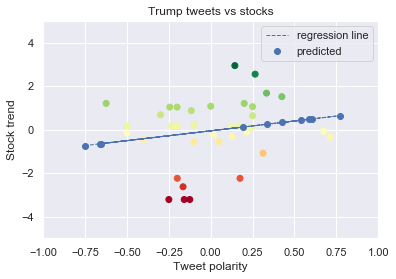

2 día(s) de bolsa contabilizado(s)
Hemos obtenido un r = 0.06447474515350668
Coeficiente de la regresión: 
 [[0.35166886]]
Mean Square Error de la regresión: 
 2.7179289730092657


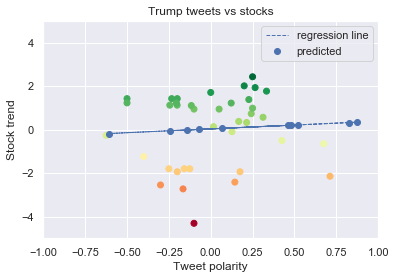

3 día(s) de bolsa contabilizado(s)
Hemos obtenido un r = 0.075004532535447
Coeficiente de la regresión: 
 [[0.5125846]]
Mean Square Error de la regresión: 
 4.3702824658290425


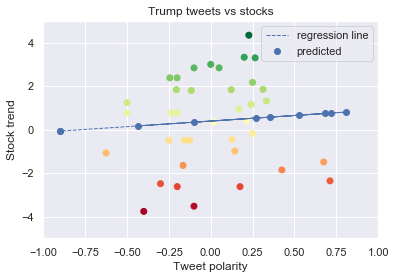

4 día(s) de bolsa contabilizado(s)
Hemos obtenido un r = 0.044971790540869146
Coeficiente de la regresión: 
 [[0.33325217]]
Mean Square Error de la regresión: 
 5.254907536755107


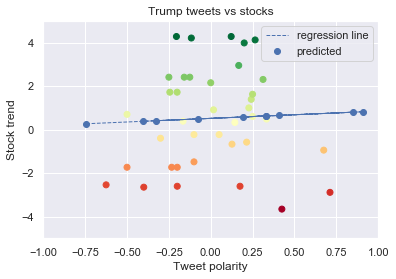

In [20]:
full_analysis(empresas, tweets, bolsa_ext, windows=4)

Como se puede ver en las gráficas y en las estadísticas, los resultados no son muy buenos. Las r de Pearson son demasiado bajas. En términos absolutos se podría decir que para un día vista influye en casi un 20% en la distribución de los datos, pero aún así es muy pobre. El estudio a varios días adelante arroja peores resultados, cosa que cuadra con la intuición de que las declaraciones del presidente se diluyen en el tiempo. 

Otra razón para estos malos resultados podría ser que los mercados de valores se encuentran influidos a través de muchos frentes diferentes, y que puede ser que un tweet de Trump se disperse entre la cantidad de fluctuaciones que hay en un día. Esto nos sería posible estudiarlo de una mejor forma si hubiéramos dispuesto de datos por horas de la bolsa, pero ese tipo de datos son de pago y se escapaba un poco del objetivo de esta investigación.

Sin embargo, algo se nos ocurrió que podría mejorar los resultados:

Si Donald Trump escribiera un tweet que fuera muy negativo, pero que fuera destinado a China, es posible que los mercados sí se vieran afectados, pero al contrario que como nosotros pensábamos, esa respuesta fuera positiva porque beneficia los objetivos estadounidenses. Por tanto decidimos continuar nuestro estudio usando datos absolutos.

### Análisis de los datos con valores absolutos

#### Para ello vamos a realizar modificaciones en las funciones para realizar los cálculos en valor absoluto

Ahora, las diferencias van a ser en valor absoluto, lo mismo que la polaridad. De esta forma íbamos a intentar explicar que si el señor @realDonaldTrump ponía un tweet cuya polaridad fuese muy extrema, podría generar cambios más intensos en los mercados.

In [21]:
def full_analysis(companies, tweets, stocks, windows):
    
    for window in range(windows):
        polarities, differences, _ = get_companies_transactions(companies, tweets, stocks, window)
        polarities = [np.abs(x) for x in polarities]
        differences = [np.abs(x) for x in differences]
        get_regression(polarities, differences, window)

In [22]:
def get_regression(polarities, differences, horizon=None):
    if horizon is not None:
        print(f'{horizon+1} día(s) de bolsa contabilizado(s)')
    # Transformación de los valores para el cálculo de la r de Pearson.
    pol = np.asarray(polarities)
    diff = np.asarray(differences)
    diff = diff.reshape(-1)
    
    coe_pearson = stats.pearsonr(pol, diff)
    print('Hemos obtenido un r = {} ' .format(coe_pearson[0]))
    
    # Creación conjunto de datos para la predicción.
    X_pred = np.empty(shape=[10,])
    for i in range(0,10):
        a = random.uniform(0, 1)
        X_pred[i] = a

    # Transformación de los datos para la regresión lineal.
    X_pred = X_pred.reshape(-1 , 1)
    pol = pol.reshape(-1,1)
    diff = diff.reshape(-1,1)
    
    regr = LinearRegression()

    regr.fit(pol, diff)

    predicts = regr.predict(X_pred)
    print('Coeficiente de la regresión: \n', regr.coef_)
    print('Mean Square Error de la regresión: \n', metrics.mean_squared_error(pol, diff))
    plot_stats(pol, diff, reg_info=[X_pred, predicts])

In [23]:
def plot_stats(polarities, differences, reg_info=None):
    
    plt.xlim((0, 1))
    plt.ylim((0, 5))
    
    plt.xlabel('Tweet polarity')
    plt.ylabel('Stock trend')
    plt.title('Trump tweets vs stocks')
    
    plt.scatter(polarities, differences, c=differences, cmap='RdYlGn')
    if reg_info is not None:
        X_pred, predicts = reg_info
        plt.scatter(X_pred, predicts,  color='b', label='predicted')
        plt.plot(X_pred, predicts, linewidth=1, linestyle='dashed', label='regression line')
        plt.legend()
    
    plt.grid(True)
    plt.show()

1 día(s) de bolsa contabilizado(s)
Hemos obtenido un r = -0.16995441209146023 
Coeficiente de la regresión: 
 [[-1.03512863]]
Mean Square Error de la regresión: 
 1.7256704833006729


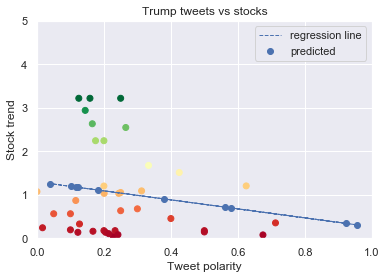

2 día(s) de bolsa contabilizado(s)
Hemos obtenido un r = -0.12563847744450207 
Coeficiente de la regresión: 
 [[-0.63126425]]
Mean Square Error de la regresión: 
 2.107991914450917


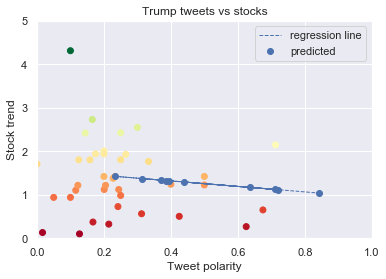

3 día(s) de bolsa contabilizado(s)
Hemos obtenido un r = -0.04845029576886048 
Coeficiente de la regresión: 
 [[-0.31467543]]
Mean Square Error de la regresión: 
 3.586500700278128


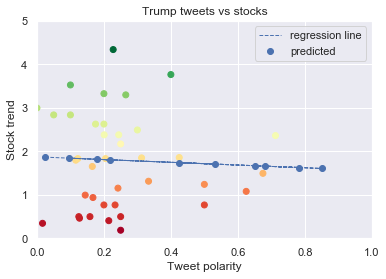

4 día(s) de bolsa contabilizado(s)
Hemos obtenido un r = 0.06145191378760333 
Coeficiente de la regresión: 
 [[0.45891191]]
Mean Square Error de la regresión: 
 4.3331437801971875


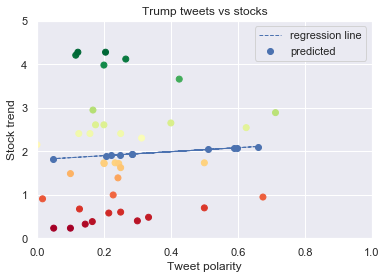

In [24]:
full_analysis(empresas, tweets, bolsa_ext, windows=4)

Los resultados usando los valores absolutos son diferentes a lo que nos habíamos esperado encontrar. Los coeficientes esta vez son negativos y los valores de los mismos son menores que los que teníamos anteriormente. Se puede intentar intuir una agrupación más lógica de los valores para un día, pero definitivamente no son adecuados para resolverse con una regresión lineal. 

Llegados a este punto empezamos a pensar que es posible que o bien la influencia de los tweets es tan pequeña que no se distingue, o bien que la forma en la que nosotros estábamos calculando las variables nos estaba llevando a resultados incompletos.


### Análisis del impacto general en la bolsa

Como último recurso, intentamos realizar un estudio en general para toda la bolsa. Es decir, estudiando la media de la polaridad de los tweets de Donald Trump en un día y ver como se comportó la totalidad de la bolsa en un día (diferencia porcentual de todas los cierres con respecto a las aperturas).

In [25]:
def plot_stats(polarities, differences, reg_info=None):
    
    plt.xlim((-1, 1))
    plt.ylim((-5, 5))
    
    plt.xlabel('Tweet polarity')
    plt.ylabel('Stock trend')
    plt.title('Trump tweets vs stocks')
    
    plt.scatter(polarities, differences, c=differences, cmap='RdYlGn')
    if reg_info is not None:
        X_pred, predicts = reg_info
        plt.scatter(X_pred, predicts,  color='b', label='predicted')
        plt.plot(X_pred, predicts, linewidth=1, linestyle='dashed', label='regression line')
        plt.legend()
    
    plt.grid(True)
    plt.show()

In [26]:
def general_analysis(tweets):
    # se suprime la hora de la fecha de publicacion de los tweets
    tweets['created_at'] = pd.to_datetime(tweets['created_at']).dt.date
    # se crea un nuevo dataframe agrupando por dia
    tweets_byday = pd.DataFrame(tweets.groupby('created_at')['text'].apply(lambda x: x.append(x)))

    mean_polarities = []
    stock_fluctuation = []
    for day in tweets_byday.index.levels[0]:

        day_tweets = tweets_byday.xs(day, level='created_at', drop_level=False).values
        day_polarities = np.array([])

        # mean polarity for the day
        for tweet in day_tweets:
            tweet_polarity = TextBlob(str(*tweet)).sentiment.polarity
            day_polarities = np.append(day_polarities, tweet_polarity)
        mean_polarities.append(np.mean(day_polarities))

        # stock values for the day, close - open
        day_stock_values = bolsa.loc[bolsa.date == day, :]

        total_close = day_stock_values.close.sum()
        total_open = day_stock_values.open.sum()
        total_fluctuation = (total_close - total_open) * 100 / total_open

        stock_fluctuation.append(total_fluctuation)
        
    mean_polarities = [x for x in mean_polarities if str(x) != 'nan']
    stock_fluctuation = [x for x in stock_fluctuation if str(x) != 'nan']
    mean_polarities = mean_polarities[:375]
    stock_fluctuation = stock_fluctuation[:375]
    
    get_regression(mean_polarities, stock_fluctuation, 4)
    

/Users/miguel_ph/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


5 día(s) de bolsa contabilizado(s)
Hemos obtenido un r = 0.04084504024787043 
Coeficiente de la regresión: 
 [[0.3613929]]
Mean Square Error de la regresión: 
 2.9963413984477865


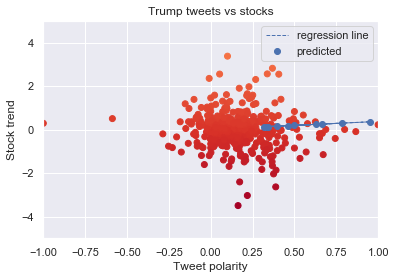

In [27]:
general_analysis(tweets)


Como podemos ver, estos resultados de nuevo nos muestran que la influencia de Donald Trump no parece ser tan fuerte desde sus Tweets como desde su sillón presidencial. La gráfica claramente no muestra ningún tipo de  relación entre los datos que nos sea significante para el problema a atajar.

A modo de trabajo futuro, dejamos nuestras ideas de como se podría intentar profundizar más en el estudio:

- Estudiar la polaridad de los tweets usando otro tipo de técnicas, por ejemplo basadas en Procesamiento de Lenguaje Natural

- Realizar una mejor investigación acerca de cómo seleccionar un tweet como candidato a ser influyente.

- Obtener datos bursátiles más desgranados que nos permitan ver influencias a corto plazo.